# Tutorial for making a ship (KT model)

---
- Ship models other than `EssoOsaka3mMMG` and `Takaoki3mMMG` can be incorporated into `pyshipsim` by implementing the models yourself. 
- In this notebook, we explain how to implement new models through the implementation of the KT model.

### Import library

In [1]:
import warnings
import numpy as np
from IPython.display import Image

import pyshipsim
from utils import font_setting

warnings.simplefilter('ignore')
font_setting()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
ImportError: Import of esso_osaka_3m's f2py mpdule failed.
ImportError: Import of esso_osaka_3m's f2py mpdule failed.
ImportError: Import of takaoki_3m's f2py mpdule failed.


# How to create new ship model

`pyshipsim` implements several modules necessary for simulation of ship maneuvering motion.
- `SurfaceShip` class : Defines state and control variables of the ship, maneuvering equations of motion, actuator response models, etc.
- `World` class : Defines state variables of the environment (wind and obstacles). Mainly, generation of irregular winds, collision detection with obstacles, etc. are implemented.
- `ManeuveringSimulation` class : Simulates ship maneuvering motion based on `SurfaceShip` and `World` instance variables.

To implement a new ship model not included in `pyshipsim/ship/assets/`, it is necessary to define a new class that inherits from the `SurfaceShip` class. A new ship model that inherits from the `SurfaceShip` class must obey the following rules
- State variables, action variables, observation variables, and some principal particulars (L and B) must be defined in the `__init__` constructor.
- The equations of motion (and the response model of the actuator) must be defined in the `ode_rhs` method.
- The observation equations or observation models must be defined in the `observe_state` method.
- The ship polygon for collision detection must be defined in the method `ship_shape`.
- The ship polygon for visualization must be defined in the `ship_appearance` method.

1. Define a class that inherits from the `SurfaceShip` clas as follows:

In [2]:
from pyshipsim import SurfaceShip

class MyKTModel(SurfaceShip):
    pass

2. Define model parameters and register variables using the `reg_principal_particular`, `reg_state_var`, `reg_action_var` and `reg_observation_var` methods.

In [3]:
class MyKTModel(SurfaceShip):
    def __init__(self, solve_method: str = "euler"):
        super().__init__(solve_method)
        # model parameter
        self.K = 0.21
        self.T = 8.8
        # register L and B
        self.reg_principal_particular(L=3.0, B=0.48925)
        # register state variables
        self.reg_state_var(name="x_position_mid [m]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="u_velo [m/s]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="y_position_mid [m]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="vm_velo [m/s]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="psi [rad]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="r_angvelo [rad/s]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="delta_rudder [rad]", ub=np.deg2rad(35), lb=-np.deg2rad(35))
        # register action variables
        self.reg_action_var(name="delta_rudder_cmd [rad]", ub=np.deg2rad(35), lb=-np.deg2rad(35))
        # register observation variables
        self.reg_observation_var(name="x_position_mid_hat [m]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="u_velo_hat [m/s]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="y_position_mid_hat [m]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="vm_velo_hat [m/s]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="psi_hat [rad]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="r_angvelo_hat [rad/s]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="delta_rudder_hat [rad]", ub=np.deg2rad(35), lb=-np.deg2rad(35))


3. Define the equations of motion and and the response model of the actuator in the `ode_rhs` method.

In [4]:
# You can use any of the models implemented in pyshipsim.
from pyshipsim import linear_delay_ode_rhs, first_order_delay_ode_rhs


class MyKTModel(SurfaceShip):
    def __init__(self, solve_method: str = "euler"):
        pass
    
    def ode_rhs(self, state, action):
        x_0, u, y_0, vm, psi, r, delta = state
        delta_cmd, U_T, gamma_T = action
        # 
        derivative_state = np.empty_like(state)
        derivative_state[0] = u * np.cos(psi) - vm * np.sin(psi)
        derivative_state[1] = 0
        derivative_state[2] = u * np.sin(psi) + vm * np.cos(psi)
        derivative_state[3] = 0
        derivative_state[4] = r
        derivative_state[5] = - 1/self.T * r + self.K/self.T * delta 
        derivative_state[6] = linear_delay_ode_rhs(delta, delta_cmd, K=np.deg2rad(20))
        return derivative_state


4. Define the observation equations or observation models in `observe_state` method.

In [5]:
class MyKTModel(SurfaceShip):
    def __init__(self, solve_method: str = "euler"):
        pass

    def ode_rhs(self, state, action):
        pass

    def observe_state(self, np_random = None):
        # If you want to generate normal distribution noise, you can use the `additive_normal_noise` method implemented in the `SurfaceShip` class.
        scale = [0.03, 0.01, 0.03, 0.01, np.deg2rad(0.1), np.deg2rad(0.1), 0.0]
        return self.additive_normal_noise(self.state, scale, np_random=np_random)


5. Define ship polygon in `ship_shape` and `ship_appearance` method.

In [6]:
# The functions to generate polygons are implemented in pyshipsim and you can use any of the following functions
from pyshipsim import simple_ship_poly, detail_ship_poly, rectangle_ship_poly, ellipse_ship_poly


class MyKTModel(SurfaceShip):
    def __init__(self, solve_method: str = "euler"):
        pass

    def ode_rhs(self, state, action):
        pass

    def observe_state(self, np_random = None):
        pass

    def ship_shape(self, state):
        eta = state[[0, 2, 4]]
        polygon = rectangle_ship_poly(eta, self.L, self.B)
        return polygon

    def ship_appearance(self, state):
        eta = state[[0, 2, 4]]
        polygon = simple_ship_poly(eta, self.L, self.B)
        return polygon
    

## Overview for creating a new ship model

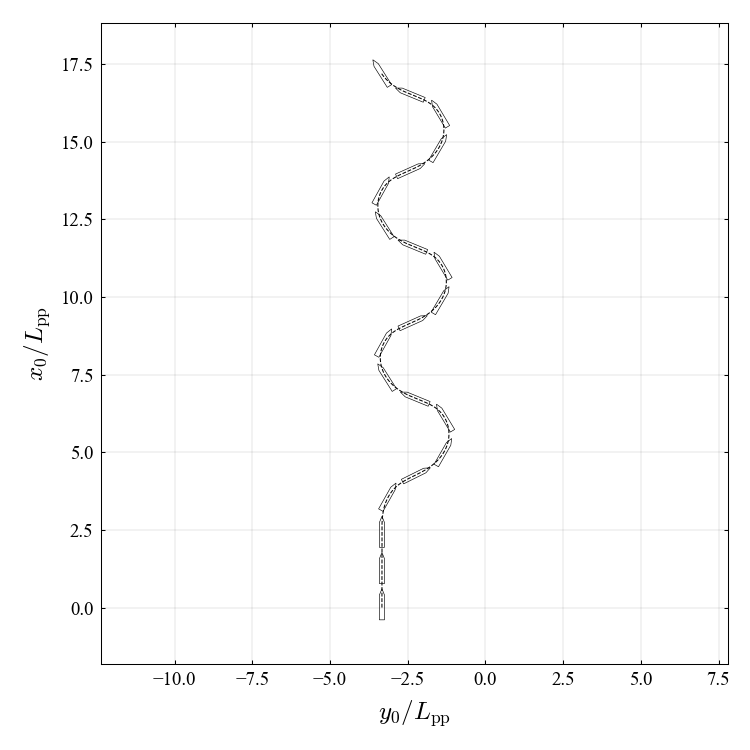

In [7]:
class MyKTModel(SurfaceShip):
    def __init__(self, solve_method: str = "euler"):
        super().__init__(solve_method)
        # model parameter
        self.K = 0.21
        self.T = 8.8
        # register L and B
        self.reg_principal_particular(L=3.0, B=0.48925)
        # register state variables
        self.reg_state_var(name="x_position_mid [m]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="u_velo [m/s]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="y_position_mid [m]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="vm_velo [m/s]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="psi [rad]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="r_angvelo [rad/s]", ub=np.inf, lb=-np.inf)
        self.reg_state_var(name="delta_rudder [rad]", ub=np.deg2rad(35), lb=-np.deg2rad(35))
        # register action variables
        self.reg_action_var(name="delta_rudder_cmd [rad]", ub=np.deg2rad(35), lb=-np.deg2rad(35))
        # register observation variables
        self.reg_observation_var(name="x_position_mid_hat [m]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="u_velo_hat [m/s]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="y_position_mid_hat [m]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="vm_velo_hat [m/s]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="psi_hat [rad]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="r_angvelo_hat [rad/s]", ub=np.inf, lb=-np.inf)
        self.reg_observation_var(name="delta_rudder_hat [rad]", ub=np.deg2rad(35), lb=-np.deg2rad(35))

    def ode_rhs(self, state, action):
        x_0, u, y_0, vm, psi, r, delta = state
        delta_cmd, U_T, gamma_T = action
        # 
        derivative_state = np.empty_like(state)
        derivative_state[0] = u * np.cos(psi) - vm * np.sin(psi)
        derivative_state[1] = 0
        derivative_state[2] = u * np.sin(psi) + vm * np.cos(psi)
        derivative_state[3] = 0
        derivative_state[4] = r
        derivative_state[5] = - 1/self.T * r + self.K/self.T * delta 
        derivative_state[6] = linear_delay_ode_rhs(delta, delta_cmd, K=np.deg2rad(20))
        return derivative_state

    def observe_state(self, np_random = None):
        scale = [0.03, 0.01, 0.03, 0.01, np.deg2rad(0.1), np.deg2rad(0.1), 0.0]
        return self.additive_normal_noise(self.state, scale, np_random=np_random)

    def ship_shape(self, state):
        eta = state[[0, 2, 4]]
        polygon = rectangle_ship_poly(eta, self.L, self.B)
        return polygon

    def ship_appearance(self, state):
        eta = state[[0, 2, 4]]
        polygon = simple_ship_poly(eta, self.L, self.B)
        return polygon
    

ship = MyKTModel()
world = pyshipsim.OpenSea()
sim = pyshipsim.ManeuveringSimulation(
    ship=ship,
    world=world,
    dt_act=1.0,
    dt_sim=0.1,
    check_collide=False,
)

# Define initial state variables
x_position_mid = 0.0
u_velo = 0.35
y_position_mid = -10.0
vm_velo = 0.0
psi = 0.0
r_angvelo = 0.0

delta_rudder = 0.0

true_wind_speed = 0.2
true_wind_direction = np.pi

state = np.array([
    x_position_mid, u_velo, y_position_mid, vm_velo, psi, r_angvelo,
    delta_rudder,
    true_wind_speed, true_wind_direction
])

# reset simulator and get the observation variables
observation = sim.reset(state, seed=100)

# control law
def z_test(t, psi, delta_rudder, delta_rudder_cmd):
    DELTA = 35*np.pi/180
    if t < 20.0:
        delta_rudder_cmd = 0.0
    else:
        if 0.0 <= delta_rudder:
            if DELTA <= psi:
                delta_rudder_cmd = -DELTA
            else:
                delta_rudder_cmd = DELTA
        else:
            if psi <= -DELTA:
                delta_rudder_cmd = DELTA
            else:
                delta_rudder_cmd = -DELTA
    return delta_rudder_cmd

# simulation roop
delta_rudder_cmd = 0.0
n_prop_cmd = 10.0
while sim.get_time() < 200:
    psi = observation[4]
    delta_rudder = observation[6]
    delta_rudder_cmd = z_test(sim.get_time(), psi, delta_rudder, delta_rudder_cmd)
    action = np.array([delta_rudder_cmd])
    observation, terminated, info = sim.step(action)
    if terminated:
        break

# save
sim.log2csv(dir='./log/tutorial_create/', fname='zigzag')
sim.log2img(dir='./log/tutorial_create/', fname='zigzag', ext_type='png')

Image("./log/tutorial_create/zigzag_trajectory.png")
